In [1]:
import os
import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
sys.path.append('..')

In [3]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms.functional import gaussian_blur
torch.jit.script = lambda x: x

import re 
import h5py
from glob import glob
from functools import partial
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from scipy.spatial.distance import pdist, cdist
from scipy import stats

from hpst.trainers.heterogenous_point_set_trainer import HeterogenousPointSetTrainer
from hpst.dataset.heterogenous_sparse_dataset import HeterogenousSparseDataset
from hpst.utils.options import Options

# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import cmasher as cmr
import seaborn as sb

In [4]:
CUDA = True
CUDA_DEVICE = 0
USE_TEX = False
TESTING_FILE = None

# TESTING_SOURCE = "interpretation"
# GRADIENT = False

# TESTING_SOURCE = "production"
# GRADIENT = False

TESTING_SOURCE= "testing"
GRADIENT = False

NETWORK = HeterogenousPointSetTrainer

In [5]:
TESTING_FILE = "/baldig/physicsprojects/roblesee/preprocessed_nova_prod5_1_respin_cvnlabmaps.h5"
BASE_DIRECTORY =  "../lightning_logs/version_82"
#CHECKPOINT_PATH = "../lightning_logs/version_35/checkpoints/epoch=9-step=75000.ckpt"
CHECKPOINT_PATH = "../lightning_logs/version_82/checkpoints/last.ckpt"

# Load checkpoint and add the test file location
options = Options.load(f"{BASE_DIRECTORY}/options.json")

if TESTING_FILE:
    options.testing_file = TESTING_FILE
else:
    options.testing_file = options.training_file.replace("training", TESTING_SOURCE)
options.num_dataloader_workers = 0

options.training_file = TESTING_FILE

if CHECKPOINT_PATH is None:
    checkpoints = glob(f"{BASE_DIRECTORY}/checkpoints/epoch*.ckpt")
    last_checkpoint = np.argmax([int(re.search("step=(.*).ckpt", s)[1]) for s in checkpoints])
    checkpoint_path = checkpoints[last_checkpoint]
else:
    checkpoint_path = CHECKPOINT_PATH
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint["state_dict"]
print(f"Loading from: {checkpoint_path}")

network = NETWORK(options)
network.load_state_dict(state_dict)

network = network.eval()

if not GRADIENT:
    for parameter in network.parameters():
        parameter.requires_grad_(False)

if CUDA:
    network = network.cuda(CUDA_DEVICE)

Loading from: ../lightning_logs/version_82/checkpoints/last.ckpt
loading training
loading file
1
1.1
2
3
4
processing file
loading file
1
1.1
2
3
4
processing file
loading testing
loading file
1
1.1
2
3
4
processing file


In [6]:
DATASET = network.testing_dataset

In [7]:
DATASET.num_events

830529

In [8]:
DATASET.hits_index.shape

torch.Size([115579145])

In [9]:
DATASET.return_index = True

In [10]:
dataloader_options = network.dataloader_options
dataloader_options["pin_memory"] = False
dataloader_options["num_workers"] = 0
dataloader_options["batch_size"] = 128
dataloader_options["drop_last"] = False

test_dataloader = network.dataloader(DATASET, **dataloader_options)

In [11]:
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

total_coords1 = []
total_coords2 = []

total_predictions1 = []
total_predictions2 = []

total_object_predictions1 = []
total_object_predictions2 = []


total_targets1 = []
total_targets2 = []

total_object_targets1 = []
total_object_targets2 = []

total_raws1 = []
total_raws2 = []

total_batch_idx1 = []
total_batch_idx2 = []

total_purs = []
total_effs = []

total_features1 = []
total_features2 = []

current_batch1 = 0
current_batch2 = 0

num_objects = 10

total_ids = []
for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
        batches2, 
        features2,
        coordinates2,
        targets2,
        object_targets2
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
        features1, coordinates1, batches1, features2, coordinates2, batches2
    )
    
    total_ids.append(ids)
    
    mask1 = ((targets1 != -1))#(object_targets1 < num_objects))
    mask2 = ((targets2 != -1))#(object_targets2 < num_objects))
    
    total_coords1.append(coordinates1[mask1].cpu())
    total_coords2.append(coordinates2[mask2].cpu())
    
    total_predictions1.append(predictions1[mask1].argmax(-1).cpu())
    total_predictions2.append(predictions2[mask2].argmax(-1).cpu())
    
    total_object_predictions1.append(object_predictions1[mask1].argmax(-1).cpu())
    total_object_predictions2.append(object_predictions2[mask2].argmax(-1).cpu())
    
    total_targets1.append(targets1[mask1].cpu())
    total_targets2.append(targets2[mask2].cpu())
    
    total_object_targets1.append(object_targets1[mask1].cpu())
    total_object_targets2.append(object_targets2[mask2].cpu())
    
    total_raws1.append(predictions1[mask1].cpu())
    total_raws2.append(predictions2[mask2].cpu())
    
    #total_batch_idx1.append(batches1[mask1].cpu() + current_batch1)# + 1)
    #current_batch1 += batches1.max().item() + 1
    total_batch_idx1.append(ids[batches1[mask1]])
    
    #total_batch_idx2.append(batches2[mask2].cpu() + current_batch2)# + 1)
    #current_batch2 += batches2.max().item() + 1    
    total_batch_idx2.append(ids[batches2[mask2]])
    
    total_ids.append(ids.cpu())
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < 32))
    mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < 32))
    
    logits = torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    targets = torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    batches = torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    object_preds = F.one_hot(object_preds, num_classes=32)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*32)+targets, dim_size=32*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(targets, num_classes=32), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    batch_target = scatter(targets, (batches*32)+targets, dim_size=32*batch_size, reduce="mean", dim=0)
    
    cost_matrix = cost_matrix.reshape((32, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, 32, -1)) # (batch_size, 10, 10)
    cpu_cm = cost_matrix.detach().cpu().numpy()
    row_inds, col_inds, indices = [], [], []
    for i, cm in enumerate(cpu_cm):
        row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
        row_ind = torch.from_numpy(row_ind)
        col_ind = torch.from_numpy(col_ind)
        index = i*torch.ones_like(row_ind)
        
        row_inds.append(row_ind)
        col_inds.append(col_ind)
        indices.append(index)

    row_inds = torch.cat(row_inds, dim=0).to(cost_matrix.device)
    col_inds = torch.cat(col_inds, dim=0).to(cost_matrix.device)
    indices = torch.cat(indices, dim=0).to(cost_matrix.device)
    
    effs = cost_matrix[indices, row_inds, col_inds]/n_true_per_prong[indices, row_inds]
    purs = cost_matrix[indices, row_inds, col_inds]/n_predictions_per_prong[indices, col_inds]

    eff_summ = scatter(effs[torch.isfinite(effs)], indices[torch.isfinite(effs)], dim_size=128, reduce="mean", dim=0)
    pur_summ = scatter(purs[torch.isfinite(purs)], indices[torch.isfinite(purs)], dim_size=128, reduce="mean", dim=0)
    
    total_purs.append(pur_summ.cpu())
    total_effs.append(eff_summ.cpu())
    
total_predictions1 = torch.cat(total_predictions1)
total_predictions2 = torch.cat(total_predictions2)
total_targets1 = torch.cat(total_targets1)
total_targets2 = torch.cat(total_targets2)
total_raws1 = torch.cat(total_raws1)
total_raws2 = torch.cat(total_raws2)
total_batch_idx1 = torch.cat(total_batch_idx1)
total_batch_idx2 = torch.cat(total_batch_idx2)
total_coords1 = torch.cat(total_coords1)
total_coords2 = torch.cat(total_coords2)
total_ids = torch.cat(total_ids)

In [12]:
total_coords1 = []
total_coords2 = []

total_predictions1 = []
total_predictions2 = []

total_object_predictions1 = []
total_object_predictions2 = []


total_targets1 = []
total_targets2 = []

total_object_targets1 = []
total_object_targets2 = []

total_raws1 = []
total_raws2 = []

total_batch_idx1 = []
total_batch_idx2 = []

total_purs = []
total_effs = []

total_features1 = []
total_features2 = []

current_batch1 = 0
current_batch2 = 0

num_objects = 10

total_ids = []
for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
        batches2, 
        features2,
        coordinates2,
        targets2,
        object_targets2
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
        features1, coordinates1, batches1, features2, coordinates2, batches2
    )
    
    mask1 = ((targets1 != -1))#(object_targets1 < num_objects))
    mask2 = ((targets2 != -1))#(object_targets2 < num_objects))
    
    total_coords1.append(coordinates1[mask1].cpu())
    total_coords2.append(coordinates2[mask2].cpu())
    
    total_predictions1.append(predictions1[mask1].argmax(-1).cpu())
    total_predictions2.append(predictions2[mask2].argmax(-1).cpu())
    
    total_object_predictions1.append(object_predictions1[mask1].argmax(-1).cpu())
    total_object_predictions2.append(object_predictions2[mask2].argmax(-1).cpu())
    
    total_targets1.append(targets1[mask1].cpu())
    total_targets2.append(targets2[mask2].cpu())
    
    total_object_targets1.append(object_targets1[mask1].cpu())
    total_object_targets2.append(object_targets2[mask2].cpu())
    
    total_raws1.append(predictions1[mask1].cpu())
    total_raws2.append(predictions2[mask2].cpu())
    
    total_features1.append(features1[mask1])
    total_features2.append(features2[mask2])
    
    #total_batch_idx1.append(batches1[mask1].cpu() + current_batch1)# + 1)
    #current_batch1 += batches1.max().item() + 1
    total_batch_idx1.append(ids[batches1[mask1]].cpu())
    
    #total_batch_idx2.append(batches2[mask2].cpu() + current_batch2)# + 1)
    #current_batch2 += batches2.max().item() + 1    
    total_batch_idx2.append(ids[batches2[mask2]].cpu())
    
    total_ids.append(ids.cpu())
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < 10))
    mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < 10))
    
    logits = torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    targets = torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    batches = torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    object_preds = F.one_hot(object_preds, num_classes=32)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*32)+targets, dim_size=32*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(targets, num_classes=32), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    batch_target = scatter(targets, (batches*32)+targets, dim_size=32*batch_size, reduce="mean", dim=0)
    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, 32, -1)) # (batch_size, 10, 10)
    cpu_cm = cost_matrix.detach().cpu().numpy()
    row_inds, col_inds, indices = [], [], []
    for i, cm in enumerate(cpu_cm):
        row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
        row_ind = torch.from_numpy(row_ind)
        col_ind = torch.from_numpy(col_ind)
        index = i*torch.ones_like(row_ind)
        
        row_inds.append(row_ind)
        col_inds.append(col_ind)
        indices.append(index)

    row_inds = torch.cat(row_inds, dim=0).to(cost_matrix.device)
    col_inds = torch.cat(col_inds, dim=0).to(cost_matrix.device)
    indices = torch.cat(indices, dim=0).to(cost_matrix.device)
    
    effs = cost_matrix[indices, row_inds, col_inds]/n_true_per_prong[indices, row_inds]
    purs = cost_matrix[indices, row_inds, col_inds]/n_predictions_per_prong[indices, col_inds]

    eff_summ = scatter(effs[torch.isfinite(effs)], indices[torch.isfinite(effs)], dim_size=128, reduce="mean", dim=0)
    pur_summ = scatter(purs[torch.isfinite(purs)], indices[torch.isfinite(purs)], dim_size=128, reduce="mean", dim=0)
    
    total_purs.append(pur_summ.cpu())
    total_effs.append(eff_summ.cpu())
    
total_predictions1 = torch.cat(total_predictions1)
total_predictions2 = torch.cat(total_predictions2)
total_targets1 = torch.cat(total_targets1)
total_targets2 = torch.cat(total_targets2)
total_raws1 = torch.cat(total_raws1)
total_raws2 = torch.cat(total_raws2)
total_batch_idx1 = torch.cat(total_batch_idx1)
total_batch_idx2 = torch.cat(total_batch_idx2)
total_coords1 = torch.cat(total_coords1)
total_coords2 = torch.cat(total_coords2)
total_ids = torch.cat(total_ids)
total_purs = torch.cat(total_purs)
total_effs = torch.cat(total_effs)
total_object_predictions1 = torch.cat(total_object_predictions1)
total_object_predictions2 = torch.cat(total_object_predictions2)
total_object_targets1 = torch.cat(total_object_targets1)
total_object_targets2 = torch.cat(total_object_targets2)
total_features1 = torch.cat(total_features1)
total_features2 = torch.cat(total_features2)

100%|██████████████████████████████████████████████████████████| 6489/6489 [18:53<00:00,  5.73it/s]


In [13]:
import matplotlib
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def imshow_segments_convex_hull(coords, targets, segments, ax):
    targets = torch.sparse_coo_tensor(
        coords.T,
        targets,
        size=(100,80)
    ).to_dense()
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    im = ax.imshow(targets.T, cmap=targets_cmap, vmin=-0.5, vmax=5.5, aspect="equal")
    
    for i in range(10):
        mask = segments == i
        if mask.sum() > 3:
            points = coords[mask].numpy()
            hull = ConvexHull(points=points)
            #convex_hull_plot_2d(hull, ax=ax)
            ax.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)

    
    return im


def imshow_segments(coords, targets, segments, weights, ax):
    
    targets = torch.sparse_coo_tensor(
        coords.T,
        targets,
        size=(100,80)
    ).to_dense()
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    im = ax.imshow(targets.T, cmap=targets_cmap, vmin=-0.5, vmax=5.5, aspect="equal")
    
    for i in range(10):
        mask = segments == i
        if mask.sum() > 3:
            points = coords[mask].numpy()
            lox = points[:,0].min()-1
            hix = points[:,0].max()+1
            loy = points[:,1].min()-1
            hiy = points[:,1].max()+1
            
            #ax.plot([lox,hix,hix,lox,lox],[loy,loy,hiy,hiy,loy])

    
    return im
    
def plot_results(i):
    mask1 = total_batch_idx1 == i+1
    mask2 = total_batch_idx2 == i+1
    
    coordsx = total_coords1[mask1]
    coordsy = total_coords2[mask2]
    predsx = total_predictions1[mask1]
    predsy = total_predictions2[mask2]
    targetsx = total_targets1[mask1]
    targetsy = total_targets2[mask2]
    objectpredsx = total_object_predictions1[mask1]
    objectpredsy = total_object_predictions2[mask2]
    objecttargetsx = total_object_targets1[mask1]
    objecttargetsy = total_object_targets2[mask2]
    featuresx = total_features1[mask1]
    featuresy = total_features2[mask2]
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.575, 0.025, 0.25])
    
    ax = axs[0][0]
    im = imshow_segments(coordsx, targetsx, objecttargetsx, featuresx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, true label")
    
    ax = axs[0][1]
    im = imshow_segments(coordsy, targetsy, objecttargetsy, featuresy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, true label")
    
    ax = axs[1][0]
    im = imshow_segments(coordsx, predsx, objectpredsx, featuresx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, prediction")
    
    ax = axs[1][1]
    im = imshow_segments(coordsy, predsy, objectpredsy, featuresy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, prediction")
    
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5])
    cbar.ax.set_yticklabels(["Background", "Muon", "Electron", "Proton", "Photon", "Pion"])
    
    fig.suptitle("id: %d, pur: %.02f, eff: %.02f" % (total_ids[i], total_purs[i], total_effs[i]))
    
    plt.show()

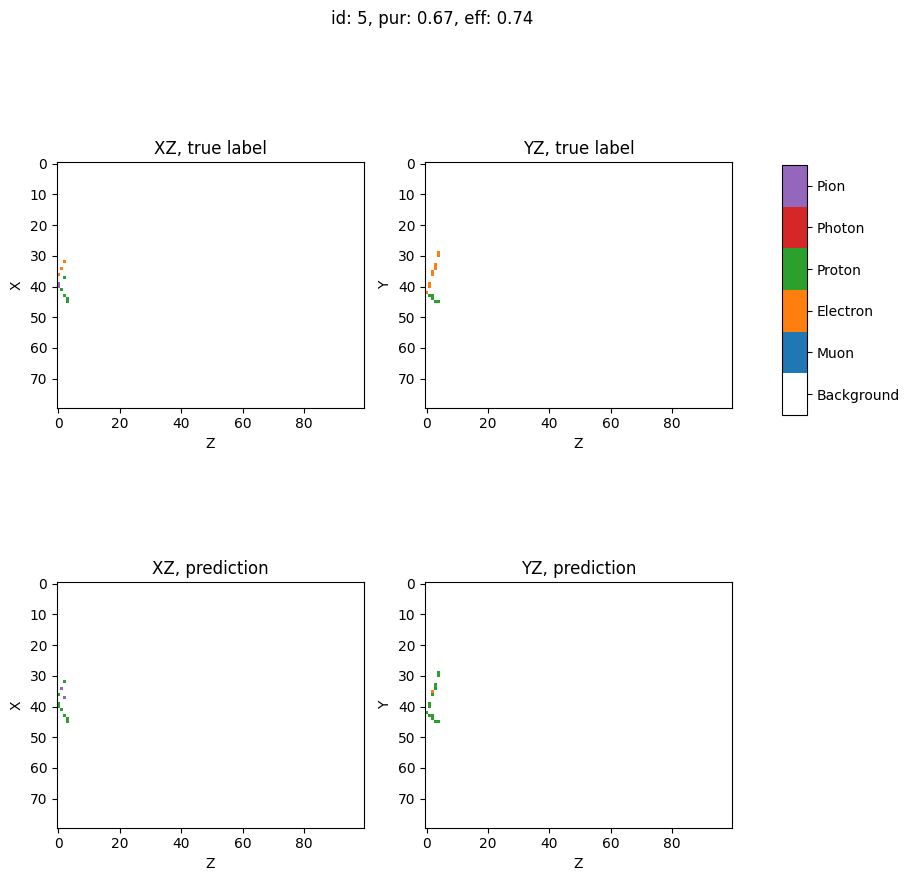

In [14]:
plot_results(5)

In [19]:
def idx_to_str(idx):
    if idx < 4:
        return "numuCC"
    if idx < 8:
        return "nueCC"
    if idx < 14:
        return "NC"
    return "Cosmic"

def imshow_labels(coords, targets, ax):
    targets = torch.sparse_coo_tensor(
        coords.T,
        targets,
        size=(100,80)
    ).to_dense()
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    im = ax.imshow(targets.T, cmap=targets_cmap, vmin=-0.5, vmax=5.5, aspect="equal")
    
    return im

def imshow_objects(coords, targets, ax):
    #vmax = min(targets.amax().item(), 20) + 0.5
    # print(targets.unique())
    targets = torch.sparse_coo_tensor(
        coords.T[:,:],
    (targets+1),
        size=(100,80)
    ).to_dense()
    targets = targets.to(float)
    targets[targets == 0] = torch.nan
    # targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    
    im = ax.imshow(targets.T, cmap="tab20", vmin=-0.5, vmax=20.5, aspect="equal")
    
    return im
    
def plot_results(i):
    #intertype = DATASET.intertype[i]
    id_ = total_ids[i]
    mask1 = total_batch_idx1.cpu() == id_
    mask2 = total_batch_idx2.cpu() == id_
    
    coordsx = total_coords1[mask1]
    coordsy = total_coords2[mask2]
    predsx = total_predictions1[mask1]
    predsy = total_predictions2[mask2]
    targetsx = total_targets1[mask1]
    targetsy = total_targets2[mask2]
    objectpredsx = total_object_predictions1[mask1]
    objectpredsy = total_object_predictions2[mask2]
    objecttargetsx = total_object_targets1[mask1]
    objecttargetsy = total_object_targets2[mask2]
    
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.575, 0.012, 0.25])
    
    ax = axs[0][0]
    im = imshow_labels(coordsx, targetsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, true label")
    
    ax = axs[0][1]
    im = imshow_labels(coordsy, targetsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, true label")
    
    ax = axs[0][2]
    im = imshow_labels(coordsx, predsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, prediction")
    
    ax = axs[0][3]
    im = imshow_labels(coordsy, predsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, prediction")
    
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5])
    cbar.ax.set_yticklabels(["Background", "Muon", "Electron", "Proton", "Photon", "Pion"])
    
    cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.25])
    
    ax = axs[1][0]
    im = imshow_objects(coordsx, objecttargetsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, segmentation true label")
    
    ax = axs[1][1]
    im = imshow_objects(coordsy, objecttargetsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, segmentation true label")
    
    ax = axs[1][2]
    im = imshow_objects(coordsx, objectpredsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, segmentation prediction")
    
    ax = axs[1][3]
    im = imshow_objects(coordsy, objectpredsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, segmentation prediction")
    
    cbar = fig.colorbar(im, cax=cbar_ax)
    
    
    
    fig.suptitle("i: %d, id: %d, type: %s, pur: %.02f, eff: %.02f" % (i, total_ids[i], "a", total_purs[i], total_effs[i]))
    
    plt.show()
    #plt.savefig("/baldig/physicsprojects/roblesee/neutrino_viz_paper/%d.png" % total_ids[i]);
    #plt.close();

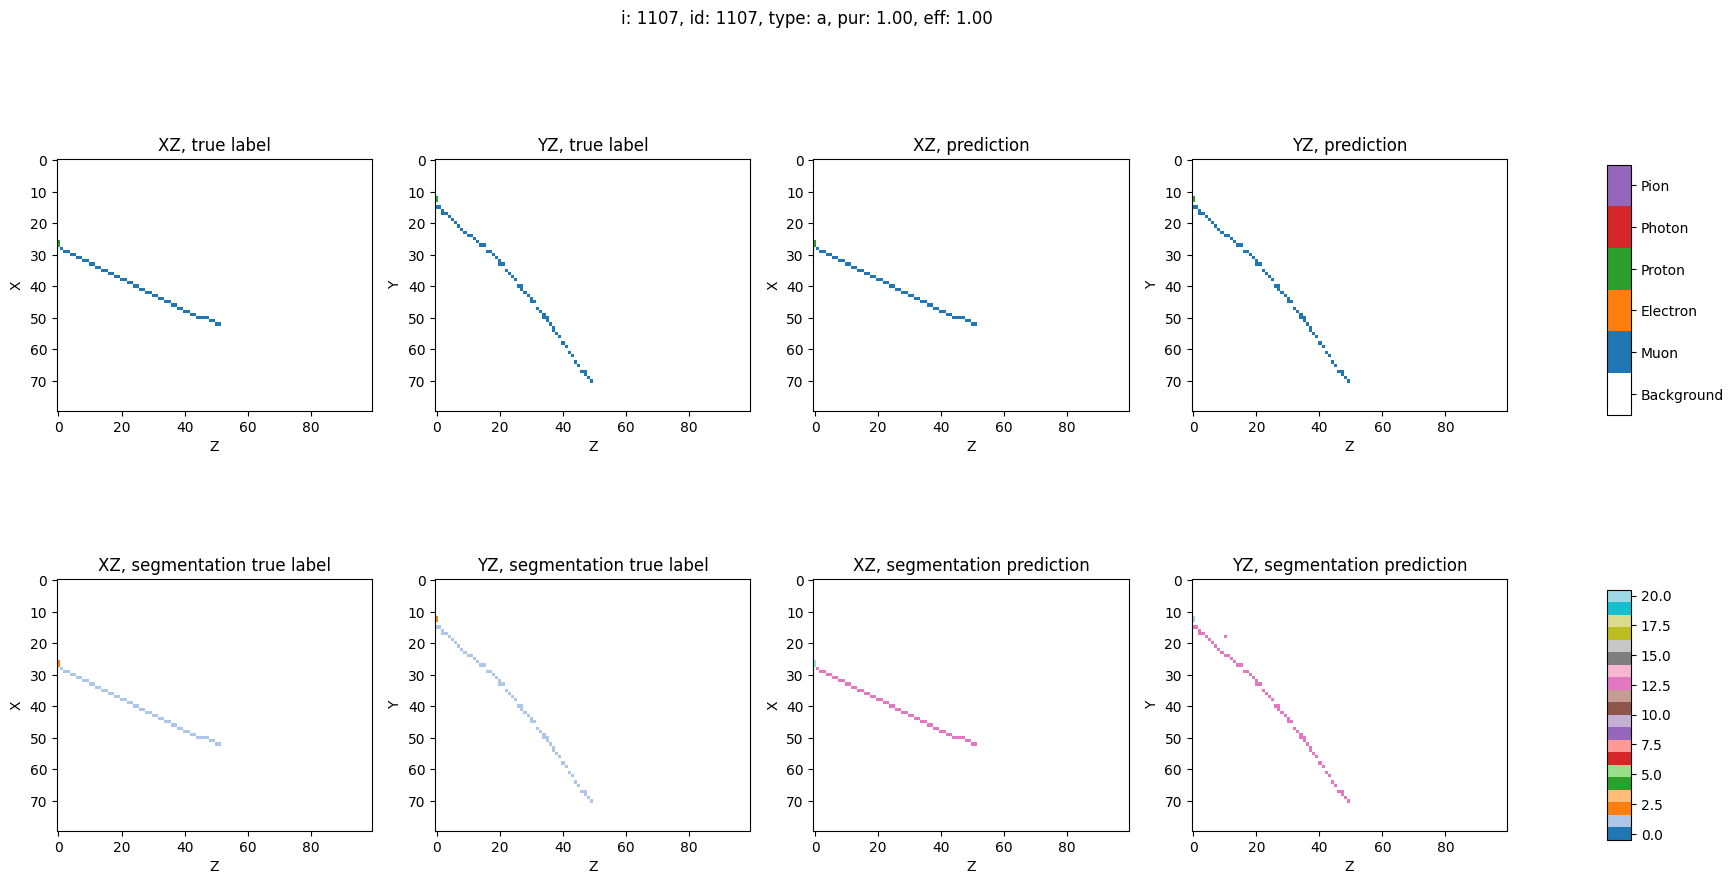

In [20]:
plot_results(1107)

In [21]:
total_ids

tensor([     0,      1,      2,  ..., 830524, 830525, 830526])

In [22]:
perm = torch.randperm(total_ids.shape[0])

ids = perm[:10000]

  0%|                                                                    | 0/10000 [00:00<?, ?it/s]

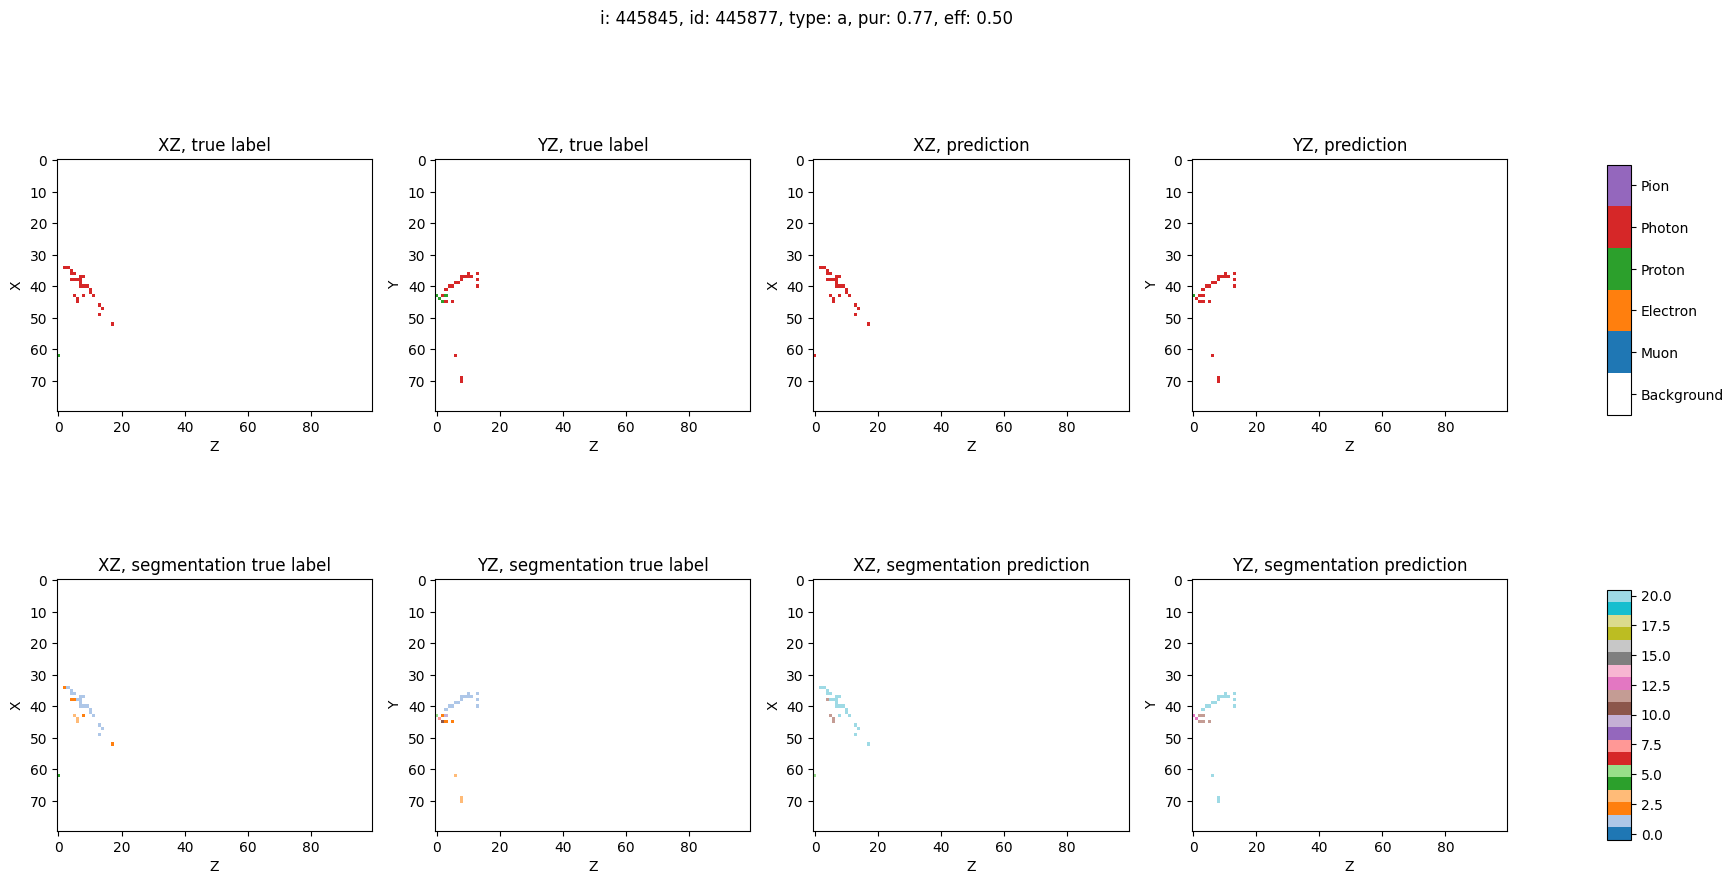

  0%|                                                          | 1/10000 [00:01<5:06:33,  1.84s/it]

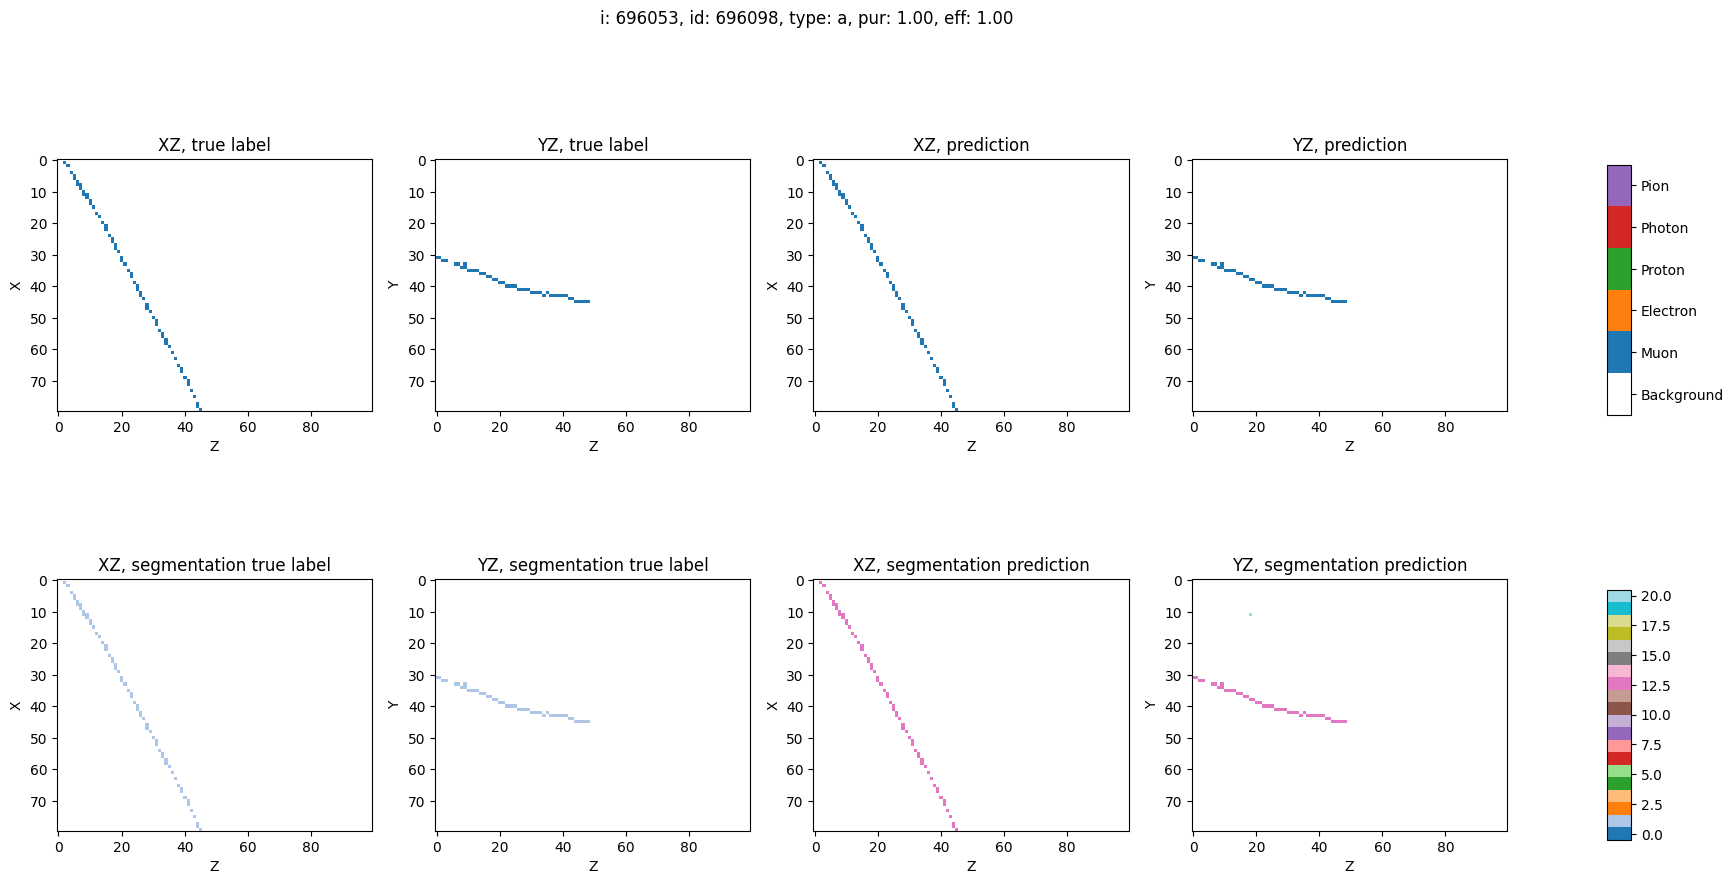

  0%|                                                          | 2/10000 [00:03<4:46:56,  1.72s/it]

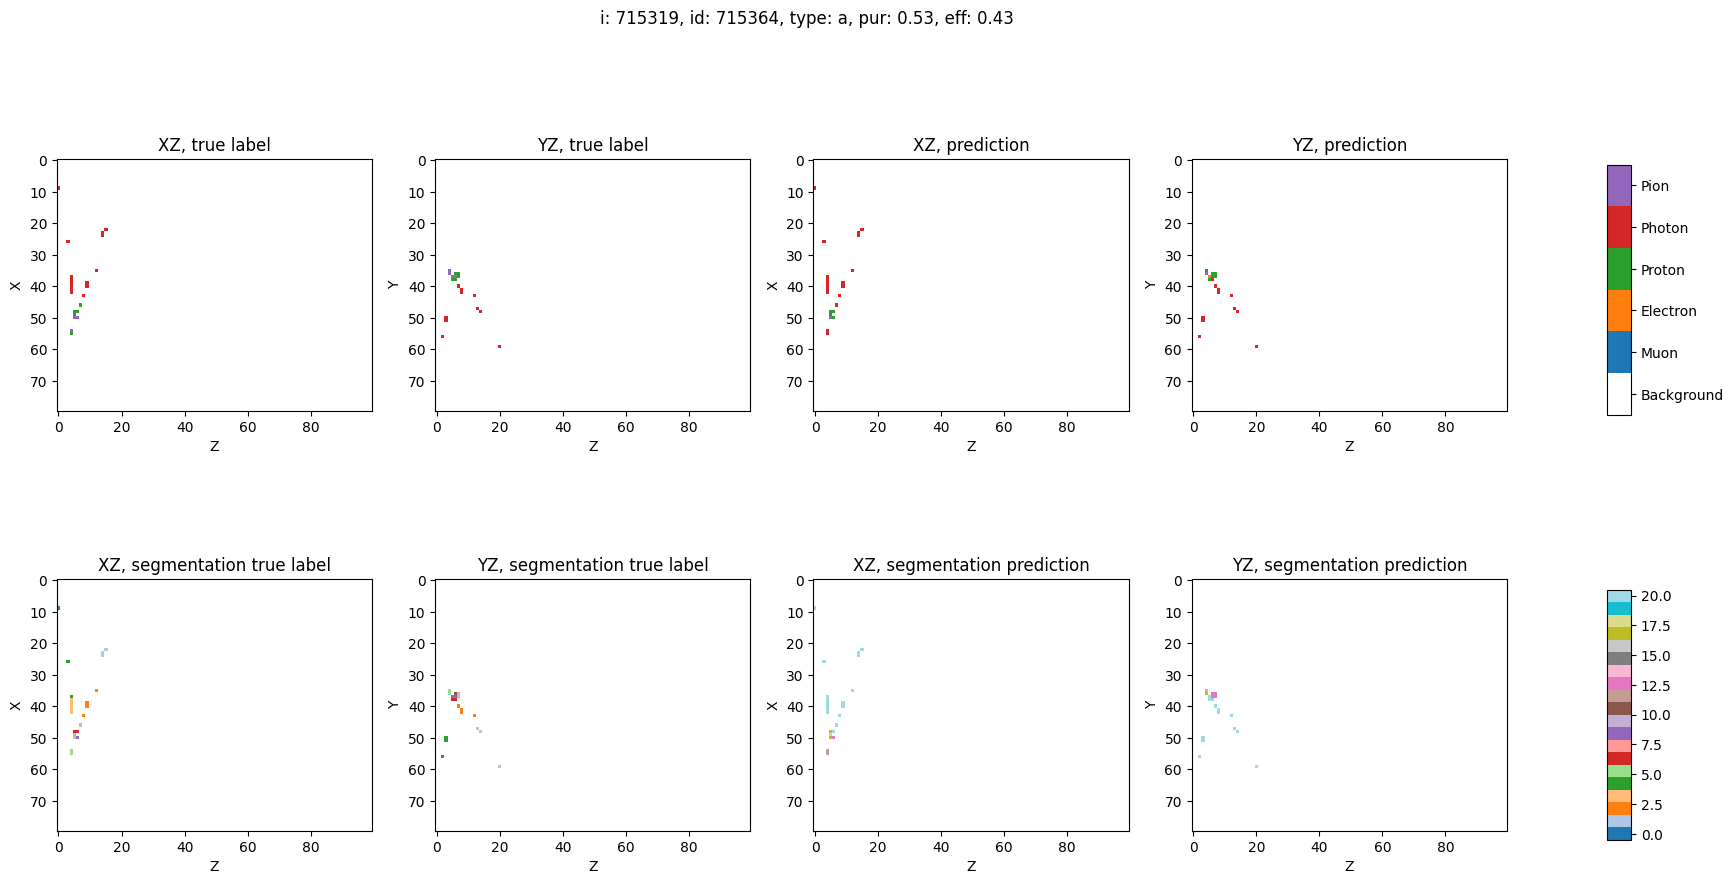

  0%|                                                          | 3/10000 [00:05<4:36:36,  1.66s/it]

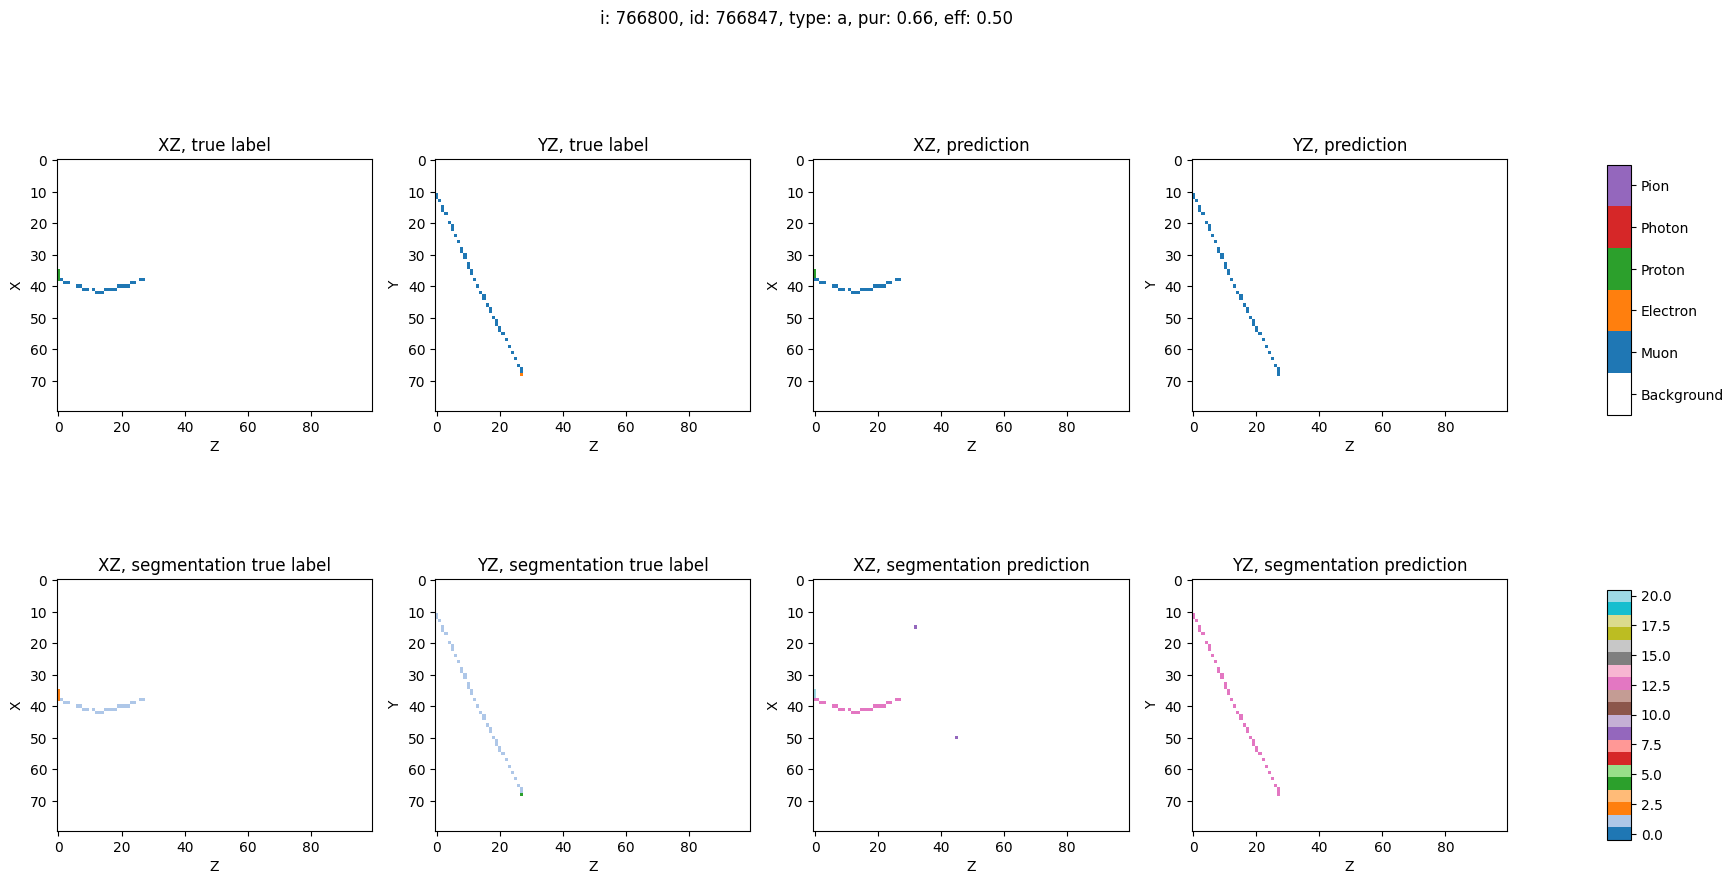

  0%|                                                          | 4/10000 [00:06<4:49:12,  1.74s/it]

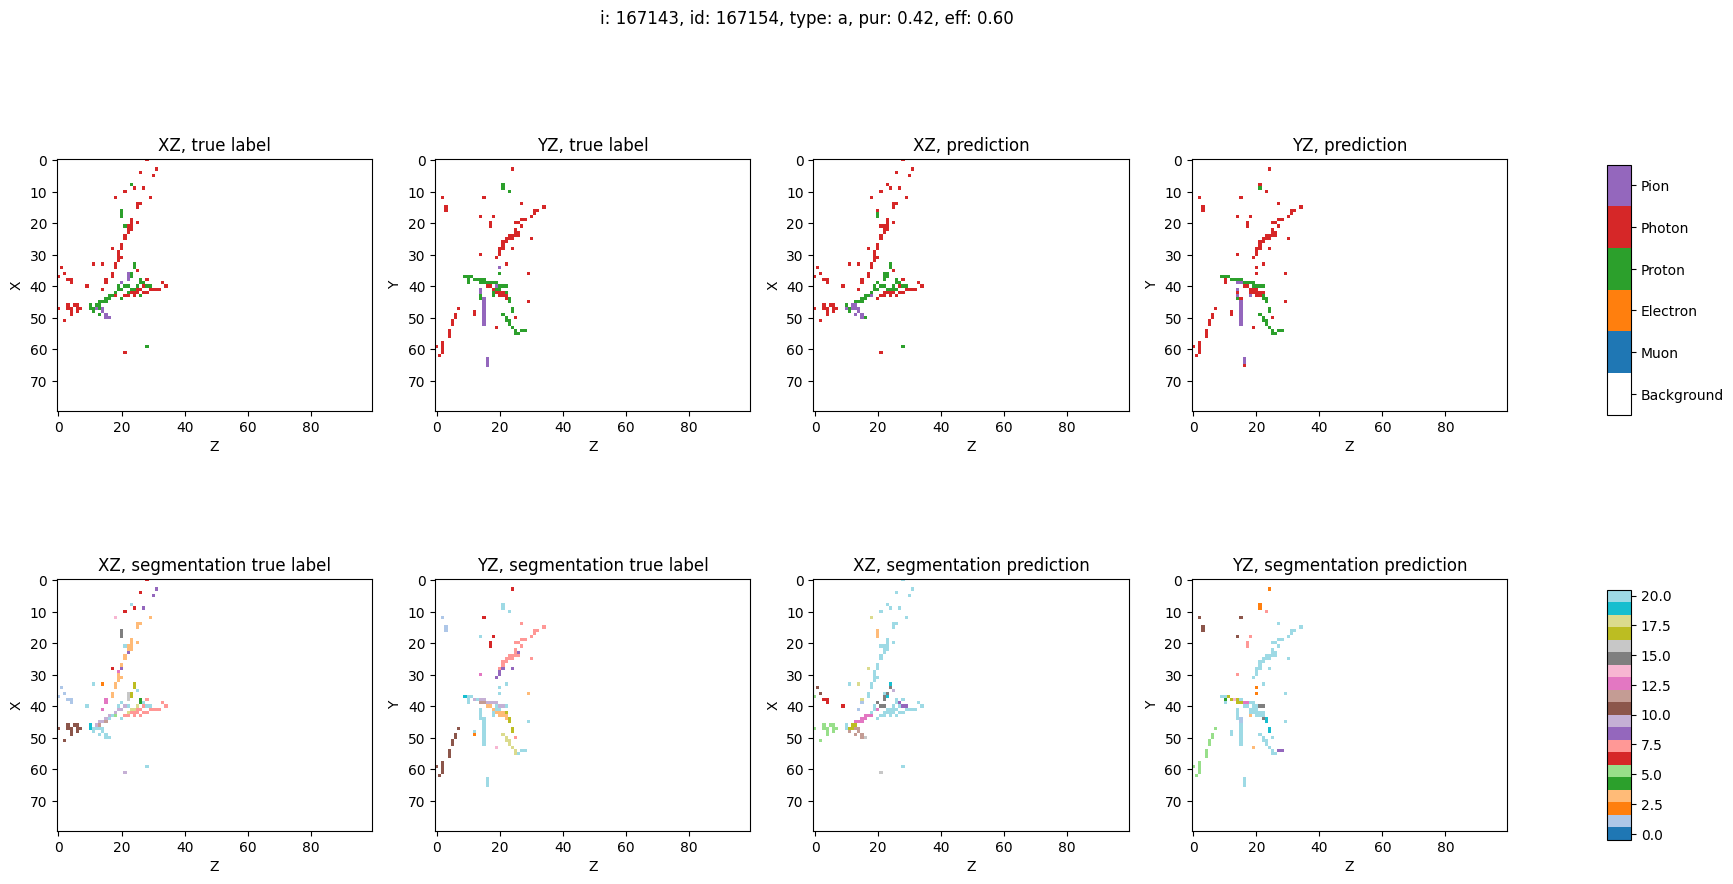

  0%|                                                          | 5/10000 [00:08<4:39:59,  1.68s/it]

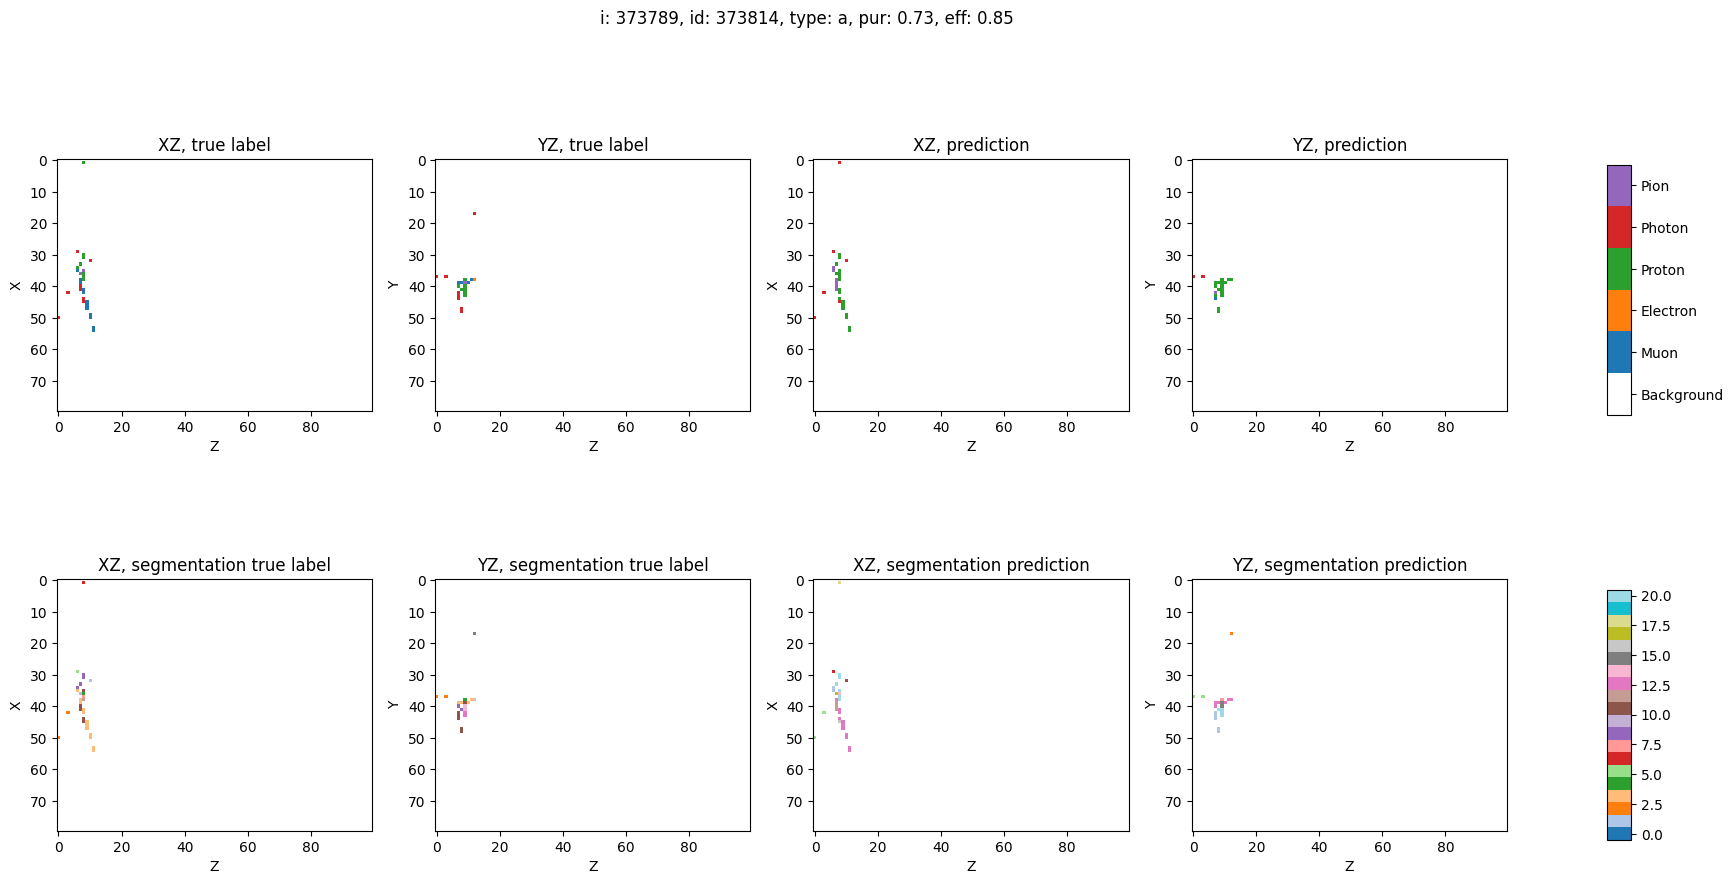

  0%|                                                          | 6/10000 [00:10<4:45:57,  1.72s/it]

KeyboardInterrupt



In [23]:
for id_ in tqdm(ids):
    plot_results(id_)

In [29]:
def idx_to_str(idx):
    if idx < 4:
        return "numuCC"
    if idx < 8:
        return "nueCC"
    if idx < 14:
        return "NC"
    return "Cosmic"

def imshow_labels(coords, targets, ax):
    targets = torch.sparse_coo_tensor(
        coords.T,
        targets,
        size=(100,80)
    ).to_dense()
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    im = ax.imshow(targets.T, cmap=targets_cmap, vmin=-0.5, vmax=5.5, aspect="equal")
    
    return im

def imshow_objects(coords, targets, ax):
    #vmax = min(targets.amax().item(), 20) + 0.5
    # print(targets.unique())
    targets = torch.sparse_coo_tensor(
        coords.T[:,:],
    (targets+1),
        size=(100,80)
    ).to_dense()
    targets = targets.to(float)
    targets[targets == 0] = torch.nan
    # targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    
    im = ax.imshow(targets.T, cmap="tab20", vmin=-0.5, vmax=20.5, aspect="equal")
    
    return im

def plot_one(i, axs):
    intertype = "" #  DATASET.intertype[i]
    id_ = total_ids[i]
    mask1 = total_batch_idx1.cpu() == id_
    mask2 = total_batch_idx2.cpu() == id_
    
    coordsx = total_coords1[mask1]
    coordsy = total_coords2[mask2]
    predsx = total_predictions1[mask1]
    predsy = total_predictions2[mask2]
    targetsx = total_targets1[mask1]
    targetsy = total_targets2[mask2]
    objectpredsx = total_object_predictions1[mask1]
    objectpredsy = total_object_predictions2[mask2]
    objecttargetsx = total_object_targets1[mask1]
    objecttargetsy = total_object_targets2[mask2]
    
    newtargetsx = objecttargetsx.clone()
    for i in range(objecttargetsx.max()):
        if (targetsx[objecttargetsx == i].shape[0]) > 0:
            newtargetsx[objecttargetsx == i] = targetsx[objecttargetsx == i].mode().values
            
    newtargetsy = objecttargetsy.clone()
    for i in range(objecttargetsy.max()):
        if (targetsy[objecttargetsy == i].shape[0]) > 0:
            newtargetsy[objecttargetsy == i] = targetsy[objecttargetsy == i].mode().values
    
    ax = axs[0][0]
    im = imshow_labels(coordsx, newtargetsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, true label, sample %d" % id_)
    
    ax = axs[0][1]
    im = imshow_labels(coordsy, newtargetsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, true label, sample %d" % id_)
    
    ax = axs[1][0]
    im = imshow_labels(coordsx, predsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, prediction, sample %d" % id_)
    
    ax = axs[1][1]
    im = imshow_labels(coordsy, predsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, prediction, sample %d" % id_)
    
    return im
    
def plot_results(i, j):
    figwidth = 20
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(figwidth,figwidth/2))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    #cbar_ax = fig.add_axes([0.9, 0.575, 0.012, 0.25])
    cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.675])

    im = plot_one(i, axs[:,0:2])
    plot_one(j, axs[:,2:4])
    
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5])
    cbar.ax.set_yticklabels(["Background", "Muon", "Electron", "Proton", "Photon", "Pion"])
    
    #cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.25])
    
    #cbar = fig.colorbar(im, cax=cbar_ax)
    
    #fig.suptitle("i: %d, id: %d, type: %s, pur: %.02f, eff: %.02f" % (i, total_ids[i], idx_to_str(intertype), total_purs[i], total_effs[i]))
    
    plt.show()
    #plt.savefig("/baldig/physicsprojects/roblesee/neutrino_viz_paper/%d.png" % total_ids[i]);
    #plt.savefig("tracks.pdf")
    #plt.savefig("tracks.pdf", format="pdf", bbox_inches="tight")
    plt.close();

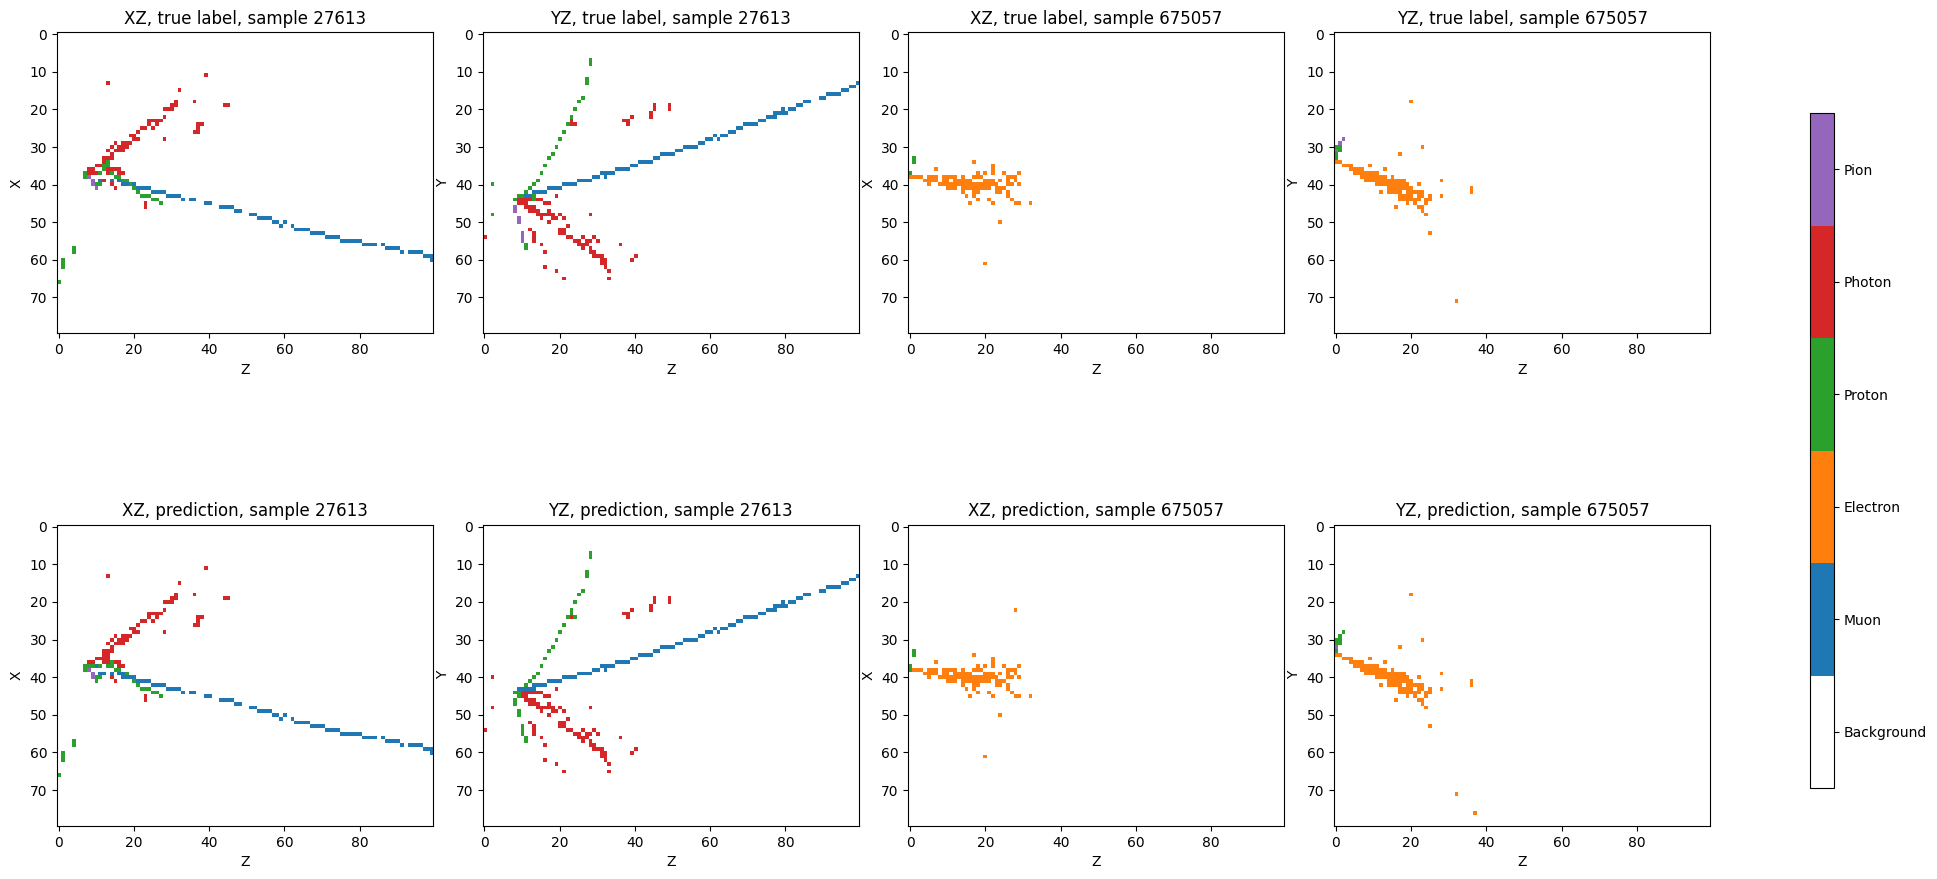

In [30]:
plot_results(27611, 675012)

In [151]:
def idx_to_str(idx):
    if idx < 4:
        return "numuCC"
    if idx < 8:
        return "nueCC"
    if idx < 14:
        return "NC"
    return "Cosmic"

def imshow_labels(coords, targets, ax):
    targets = torch.sparse_coo_tensor(
        coords.T,
        targets,
        size=(100,80)
    ).to_dense()
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    im = ax.imshow(targets.T, cmap=targets_cmap, vmin=-0.5, vmax=5.5, aspect="equal")
    
    return im

def imshow_objects(coords, targets, ax):
    #vmax = min(targets.amax().item(), 20) + 0.5
    # print(targets.unique())
    targets = torch.sparse_coo_tensor(
        coords.T[:,:],
    (targets+1),
        size=(100,80)
    ).to_dense()
    targets = targets.to(float)
    targets[targets == 0] = torch.nan
    # targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    
    im = ax.imshow(targets.T, cmap="tab20", vmin=-0.5, vmax=32.5, aspect="equal")
    
    return im
    
def plot_results(i):
    #intertype = DATASET.intertype[i]
    id_ = total_ids[i]
    mask1 = total_batch_idx1.cpu() == id_
    mask2 = total_batch_idx2.cpu() == id_
    
    coordsx = total_coords1[mask1]
    coordsy = total_coords2[mask2]
    predsx = total_predictions1[mask1]
    predsy = total_predictions2[mask2]
    targetsx = total_targets1[mask1]
    targetsy = total_targets2[mask2]
    objectpredsx = total_object_predictions1[mask1]
    objectpredsy = total_object_predictions2[mask2]
    objecttargetsx = total_object_targets1[mask1]
    objecttargetsy = total_object_targets2[mask2]
    
    mask1 = (objectpredsx.unsqueeze(0) == objectpredsy.unsqueeze(1)).any(dim=0)
    mask2 = (objectpredsx.unsqueeze(0) == objectpredsy.unsqueeze(1)).any(dim=1)
    
    coordsx = coordsx[mask1]
    coordsy = coordsy[mask2]
    predsx = predsx[mask1]
    predsy = predsy[mask2]
    targetsx = targetsx[mask1]
    targetsy = targetsy[mask2]
    objectpredsx = objectpredsx[mask1]
    objectpredsy = objectpredsy[mask2]
    objecttargetsx = objecttargetsx[mask1]
    objecttargetsy = objecttargetsy[mask2]
    
    #print(coordsx)
    #print(coordsy)
    #print(objectpredsx.unique())
    #print(objectpredsy.unique())
    
    scatterindexx = coordsx[:,0].int() * 32 + objectpredsx
    scatterindexy = coordsy[:,0].int() * 32 + objectpredsy
    
    #print(scatterindexx)
    #print(scatterindexy.shape, ((1+coordsy[coordsy[:,0] < 99,0].int()) * 32 + objectpredsy).shape)
    
    # imputed y value for XZ view
    imputedy = scatter(torch.cat([coordsy[:,1], coordsy[coordsy[:,0] < 99, 1]]), 
                       torch.cat([scatterindexy, (1+coordsy[coordsy[:,0] < 99,0].int()) * 32 + objectpredsy[coordsy[:,0] < 99]]),
                       dim_size=32*100, reduce="mean", dim=0)
    # imputed x value for YZ view
    imputedx = scatter(torch.cat([coordsx[:,1], coordsx[coordsx[:,0] < 99,1]]), 
                       torch.cat([scatterindexx, (1+coordsx[coordsx[:,0] < 99,0].int()) * 32 + objectpredsx[coordsx[:,0] < 99]]), 
                       dim_size=32*100, reduce="mean", dim=0)
    
    imputedy_x = imputedy[scatterindexx]
    imputedx_y = imputedx[scatterindexy]
    
    #print(imputedy_x, imputedx_y)
    
    #intersection = objectpredsx.unique()[(objectpredsx.unique().unsqueeze(0) == objectpredsy.unique().unsqueeze(1)).any(dim=0)]
    #print(intersection)
    plotmaskx = ... #(objectpredsx.unsqueeze(0) != objectpredsy.unsqueeze(1)).all(dim=0)
    plotmasky = ... #(objectpredsx.unsqueeze(0) != objectpredsy.unsqueeze(1)).all(dim=1)
    #plotmaskx = imputedy_x > 0
    #plotmasky = imputedx_y > 0
    
    imputed_coordsx = torch.stack([
        coordsx[:,1], # x
        imputedy_x, # imputed y
        coordsx[:,0] # z
    ], dim=-1)
    
    imputed_coordsy = torch.stack([
        imputedx_y, # imputed x
        coordsy[:,1], # y
        coordsy[:,0] # z
    ], dim=-1)

    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.575, 0.012, 0.25])
    
    ax = axs[0][0]
    im = imshow_labels(coordsx[plotmaskx], targetsx[plotmaskx], ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, true label")
    
    ax = axs[0][1]
    im = imshow_labels(coordsy[plotmasky], targetsy[plotmasky], ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, true label")
    
    ax = axs[0][2]
    im = imshow_labels(coordsx[plotmaskx], predsx[plotmaskx], ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, prediction")
    
    ax = axs[0][3]
    im = imshow_labels(coordsy[plotmasky], predsy[plotmasky], ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, prediction")
    
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5])
    cbar.ax.set_yticklabels(["Background", "Muon", "Electron", "Proton", "Photon", "Pion"])
    
    cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.25])
    
    ax = axs[1][0]
    im = imshow_objects(coordsx[plotmaskx], objecttargetsx[plotmaskx], ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, segmentation true label")
    
    ax = axs[1][1]
    im = imshow_objects(coordsy[plotmasky], objecttargetsy[plotmasky], ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, segmentation true label")
    
    ax = axs[1][2]
    im = imshow_objects(coordsx[plotmaskx], objectpredsx[plotmaskx], ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, segmentation prediction")
    
    ax = axs[1][3]
    im = imshow_objects(coordsy[plotmasky], objectpredsy[plotmasky], ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, segmentation prediction")
    
    cbar = fig.colorbar(im, cax=cbar_ax)
    
    
    
    fig.suptitle("i: %d, id: %d, type: %s, pur: %.02f, eff: %.02f" % (i, total_ids[i], "a", total_purs[i], total_effs[i]))
    
    plt.show()
    #plt.savefig("/baldig/physicsprojects/roblesee/neutrino_viz_paper/%d.png" % total_ids[i]);
    #plt.close();
    
    # 3d scatterplot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(imputed_coordsx[:,1], imputed_coordsx[:,2], imputed_coordsx[:,0], c=objectpredsx)
    ax.set_xlabel('Y')
    ax.set_ylabel('Z')
    ax.set_zlabel('X')
    plt.show()
    
    # 3d scatterplot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(imputed_coordsy[:,1], imputed_coordsy[:,2], imputed_coordsy[:,0], c=objectpredsy)
    ax.set_xlabel('Y')
    ax.set_ylabel('Z')
    ax.set_zlabel('X')
    plt.show()
    plt.close()

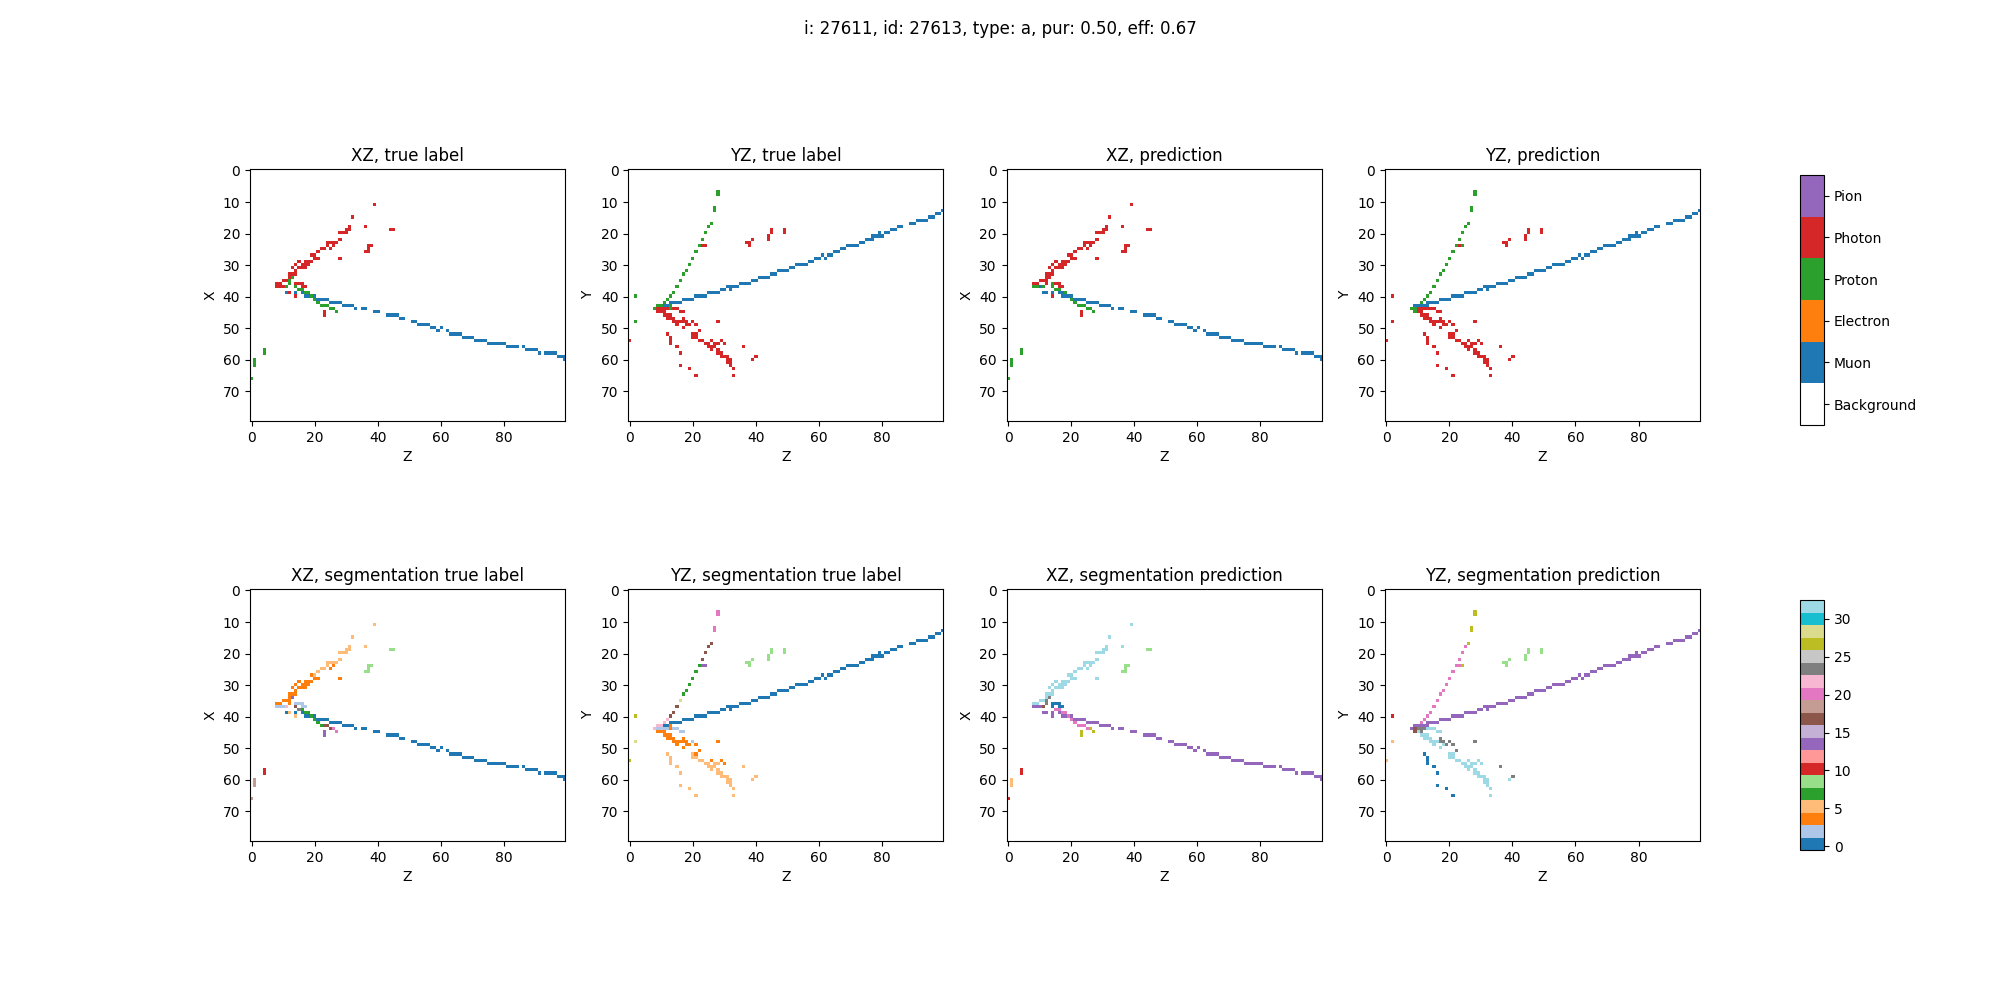

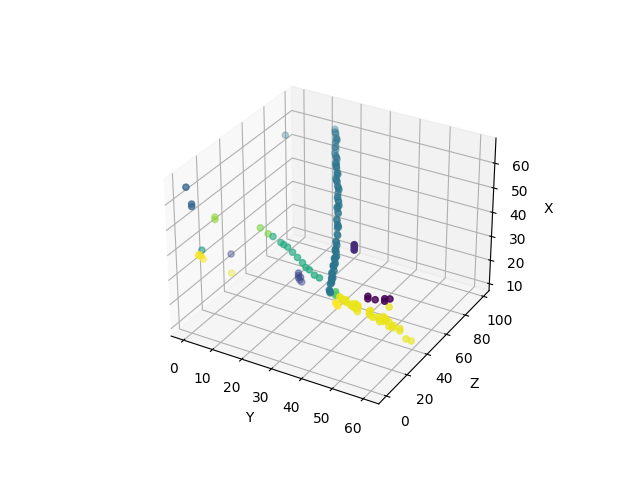

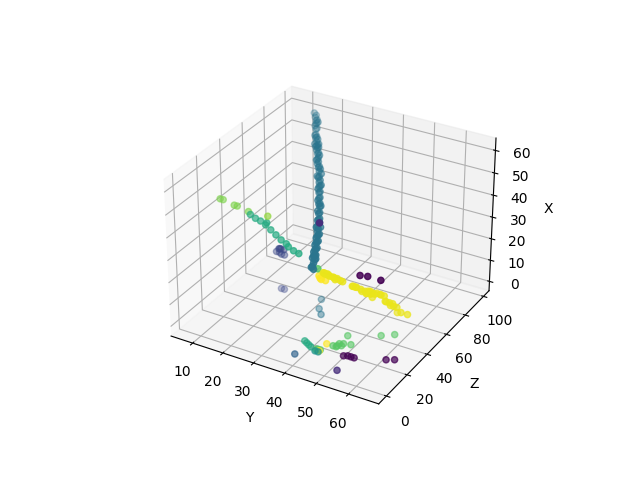

In [152]:
%matplotlib widget
plot_results(27611)

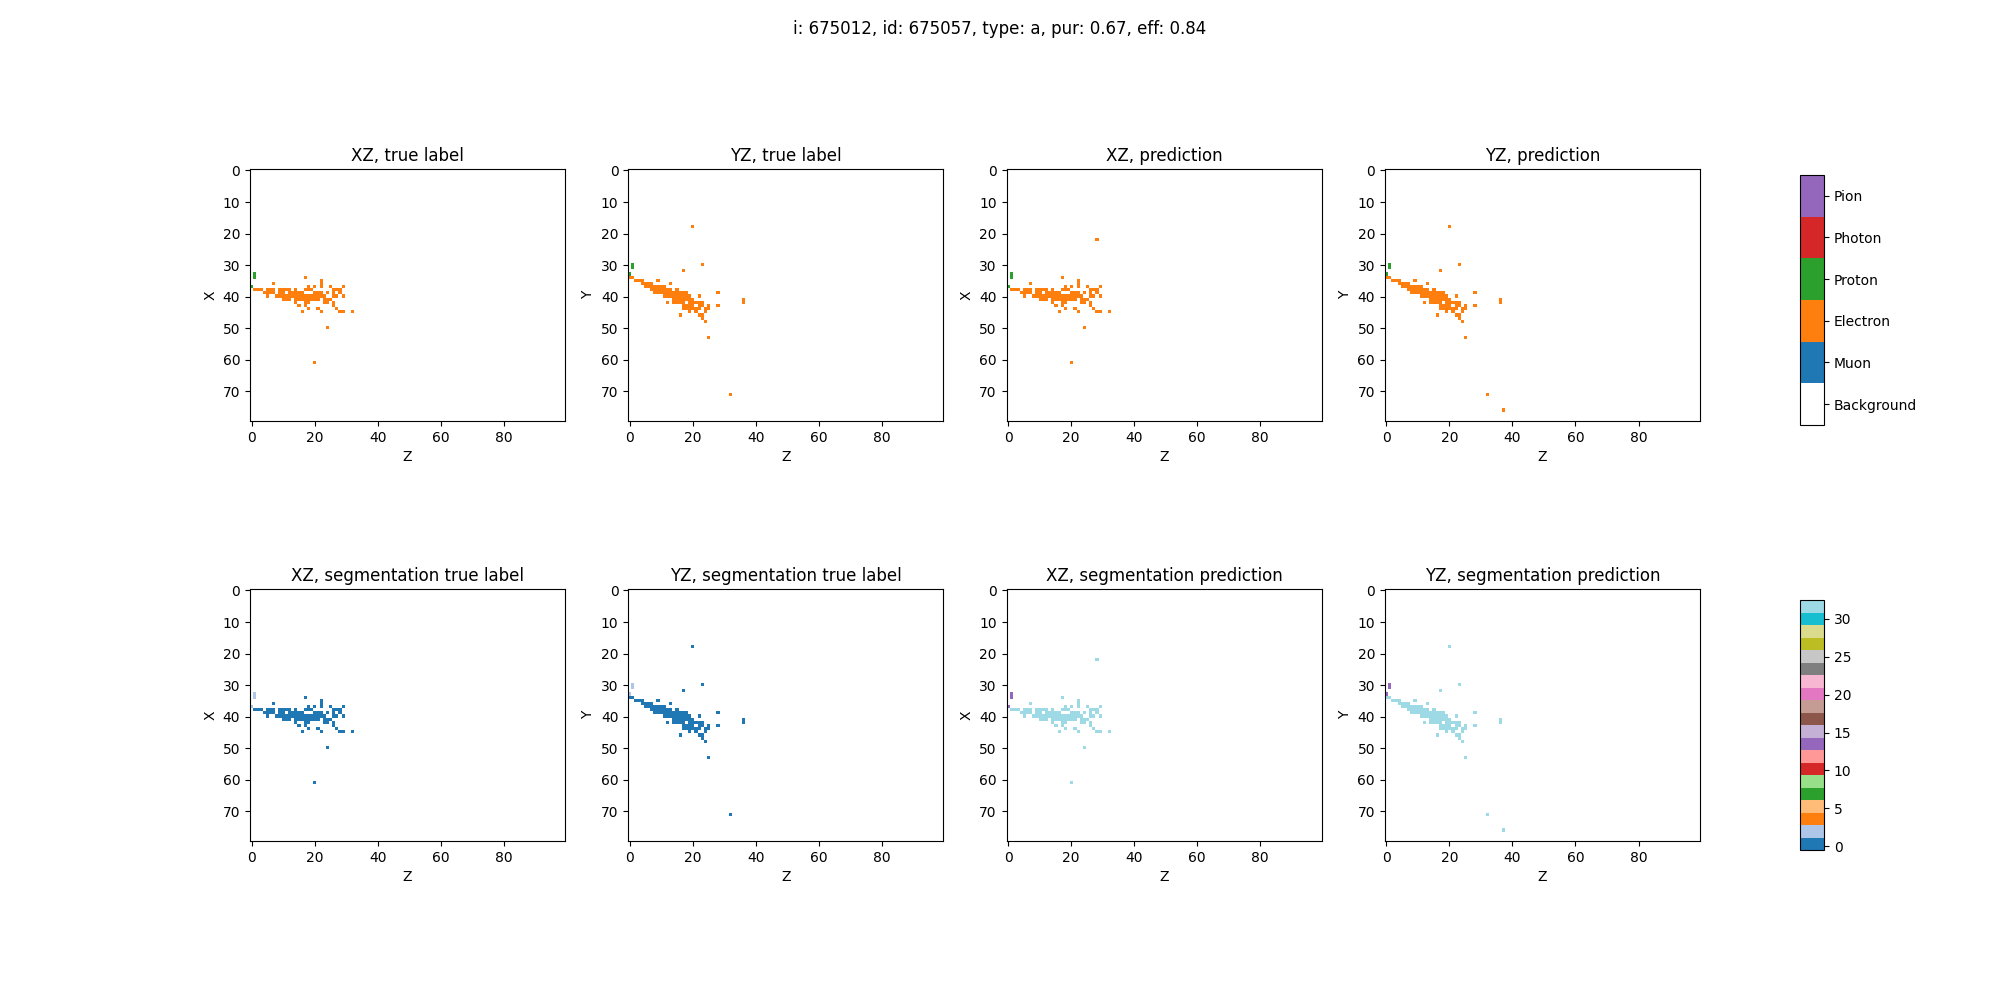

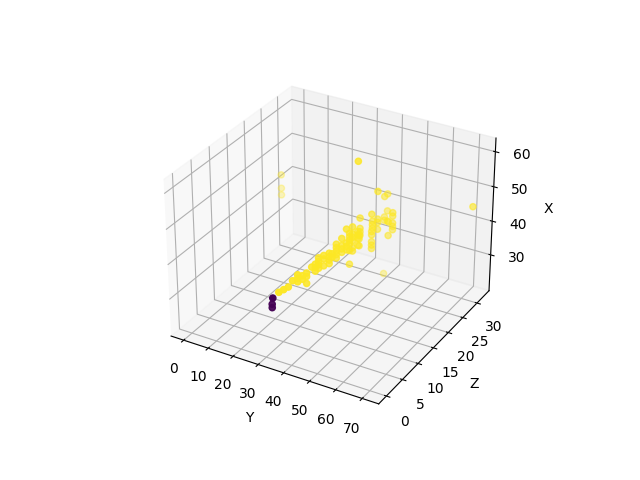

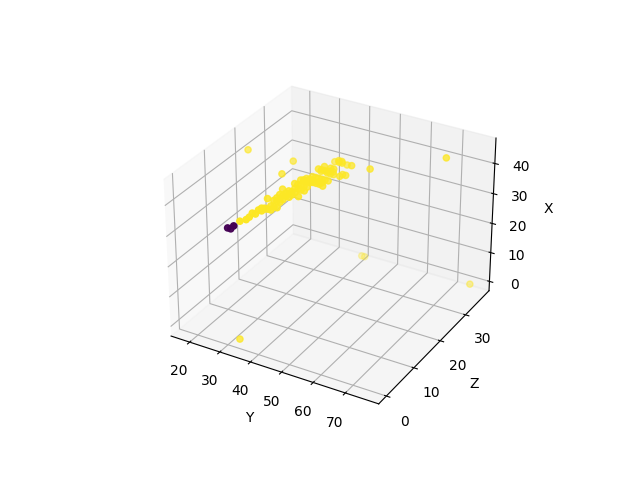

In [153]:
%matplotlib widget
plot_results(675012)